### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [153]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
# verbose = True   # print calculation output and weights and bias matrices 
verbose = False  # print calculation output only

In [155]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

In [156]:
def print_parameters(parameters):
  # number of parameters (e.g sum (weights + bias to each neuron and output))
  # MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
  # print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(parameters())}\n')
  print(f'Total parameters: {len(parameters())}\n')  

  # print first 5 parameters
  for i, v in enumerate(parameters()):
    if i < 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')
  
  print('---')

  # print last 5 parameters   
  for i, v in enumerate(parameters()):
    if i >= len(parameters()) - 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')

In [157]:
def get_wt_n_b_mats(layers, verbose=False):
  ''' Get neuron's weights and bias for each layer.
  Inputs: If n = MLP(2, [3, 3, 1]), input is n.layers.

  return: two lists of np.arrays. The first list is weight matrix for each layer
          The second list is the bias matrix for each layer 
  '''
  layer_cnt = len(layers)  # number of layers
  w_mats = []  # list of weights matrix for each layer 
  b_mats = []  # list of bias matrix for each layer
  if verbose:
    print(f'layer_cnt: {layer_cnt}\n')
  for i, layer in enumerate(layers):
      neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer
      if verbose: 
        print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

        print('----')
      b_mat = []  # accumulate neuon's bias for each row     
      for j, neuron in enumerate(layer.neurons):
          if verbose:
            print(f'layer: {i}, neuron {j}')
          b = neuron.b.data  # bias of neuron 
          w_row = []  # accumulate neuon's weights for each row
          b_row = []  # accumulate neuon's bias for each row
          for k, w in enumerate(neuron.w):
              w_row.append(w.data)
              if verbose:
                print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
          if j == 0:            
              w_mat = np.array([w_row])
          else:
              w_mat = np.vstack((w_mat, w_row))
          
          b_mat.append(b)
          if verbose:
            print(f'b:  {b:10.7f}\n')
            print(f'b:  {b:10.7f}')        
            print(f'b_mat:  {b_mat}\n')
      w_mats.append(w_mat)  
      b_mats.append(np.array([b_mat]))        
      if verbose:
          print('------')

  zipped_w_n_b = zip(w_mats, b_mats)
  if verbose:
    for i, w_n_b in enumerate(zipped_w_n_b):
      print(f'layer: {i}')  # 1st layer is 0    
      print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
      print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  

  return w_mats, b_mats

In [158]:
def forward_pass(layers, verbose=verbose):
  # Get Neural Network's Weights and Biases Matrices
  # w_mats, b_mats = get_wt_n_b_mats(n.layers, verbose=verbose)
  w_mats, b_mats = get_wt_n_b_mats(layers, verbose=verbose)

  # Calculate Neural Network Output and Loss with Matrix Multiplication
  for layer in range(len(layers)):
    if layer == 0:  # first layer, use given inputs xs as inputs
      input = xs_mats_T[layer]
    else:  # after first layer, use outputs from preceding layers as inputs
      input = output

    weights = w_mats[layer]
    bias = np.transpose(b_mats[layer])

    weights_x_input = np.matmul(weights, input)
    weights_x_input_plus_bias = weights_x_input + bias

    # output = np.tanh(np.matmul(weights, input) + bias)
    output = np.tanh(weights_x_input_plus_bias)

    print(f'{"-"*50}')
    print(f'Calculate Output of Layer: {layer}')    
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_+_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')    

    # print(f'output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    
    print(f'Layer {layer} Output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    

  yout = output[0]
  err = (yout - ys)
  err_sq = (err**2)
  loss_sum = err_sq.sum()
  loss_mean = err_sq.mean()

  # print(f'-- Manual calculation results of neural network output and prediction error --')
  print(f'-- Results of neural network outputs and Loss --')  
  print(f'yout:           {yout}')   
  print(f'desired output: {ys}')   
  print(f'err:            {err}')
  print(f'err_sq:         {err_sq}')
  print(f'loss_mean:      {loss_mean}')
  print(f'loss_sum:       {loss_sum}')

  return yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats


### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [159]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [160]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [161]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

#   &nbsp;
# - Human Brain and Artificial Neural Network - 

### Neurons in Human Brain
![](..\karpathy\img\neuron_of_human_brain.png)

### Simple Artificial Neural Network<br>* input layer: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 nodes<br>* hidden layer 1: &nbsp;3 nodes<br>* hidden layer 2:&nbsp;&nbsp;3 nodes<br>*  output layer: &nbsp;&nbsp;&nbsp; 1 node<br>* node's bias and activation function are not shown

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

### Artificial Neuron Function

<img src="..\karpathy\img\Artificial Neuron Function.png">

#   &nbsp;
# - Visualize Math Operations in a Hidden Layer -

### * Assume hidden layer with two inputs (X0, X1), and three neurons (b0, b1, b2)<br>* Two sets of inputs (X0, X1) are shown in different shades of gray<br>* Two sets of outputs (Y0, Y1, Y2) are shown in corresponding shades of gray<br>* Multiple sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

# &nbsp;
# - Create Simple Neural Network -
##### MLP(2, [3, 3, 1])<br>* 2 input nodes<br>* 3 neurons in hidden layer 1<br>* 3 neurons in hidden layer 2<br>* 1 output node
##### Initialize Neurons Parameters <br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = &nbsp;&nbsp;&nbsp;&nbsp;  9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = &nbsp;&nbsp;&nbsp; 4<br>*  total parameters: 25

In [162]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# if verbose:
if True:
  print("Neuron parameters, initialized with random numbers")
  print_parameters(n.parameters)

Neuron parameters, initialized with random numbers
Total parameters: 25

i:  0,   0.3279110816
i:  1,   0.3927094767
i:  2,  -0.3900707518
i:  3,   0.7236720477
i:  4,  -0.6658996559
---
i: 20,   0.4359785775
i: 21,   0.5106230509
i: 22,   0.5680953191
i: 23,   0.4431488598
i: 24,  -0.9263554258


# &nbsp;
# - Set Inputs, Desired Outputs, Learning Rate -
##### Inputs<br>* 1st set: [2.0, 3.0]<br>* 2nd set: [3.0, -1.0]
##### Desired Outputs<br>* [1.0, -1.0] for all input sets
##### Learning Rate<br>* 0.05

In [163]:
# inputs
xs = [
  [2.0, 3.0],
  [3.0, -1.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [164]:
# if True:
if verbose:
	# print weights and bias of each layer
	for i, layer in enumerate(n.layers):
		neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer 
		print(f'layer: {i}, neuron_cnt: {neuron_cnt}, layer: {layer}')

# &nbsp;
# - Calculate Neural Network Outputs and Loss (i.e. Prediction Errors) -
##### * transpose inputs<br>* select activation function<br>* calculate output, (a.k.a) Forward Pass<br>* calculate Loss

##### Transpose Inputs

In [165]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.,  3.],
       [ 3., -1.]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.,  3.],
       [ 3., -1.]])]


##### Common Activation Functions

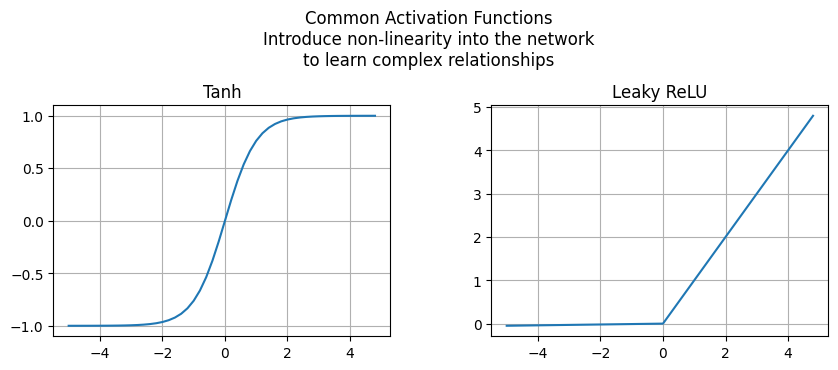

In [166]:
# Common Activation Functions
x = np.arange(-5, 5, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x, np.tanh(x))
ax1.set_title("Tanh")
ax1.grid()

a = x[x < 0]*0.01
b = x[x >= 0]
y = np.concatenate((a, b))
ax2.grid()
ax2.plot(x, y)
ax2.set_title("Leaky ReLU")

plt_title = "Common Activation Functions\nIntroduce non-linearity into the network\nto learn complex relationships"
plt.suptitle(plt_title , fontsize=12, y=1.2)
plt.subplots_adjust(wspace=0.3)
plt.show()

##### Calculate Outputs and Loss Using Tanh Activation

In [167]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.32791108  0.39270948]
 [ 0.72367205 -0.66589966]
 [-0.41164514 -0.75396648]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[ 1.83395059  0.59102377]
 [-0.55035487  2.8369158 ]
 [-3.08518972 -0.48096895]]

bias (3, 1):
[[-0.39007075]
 [-0.78898639]
 [ 0.22411575]]

weights_x_inputs_+_bias (3, 2):
[[ 1.44387984  0.20095302]
 [-1.33934126  2.04792941]
 [-2.86107396 -0.25685319]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.89447605  0.19829104]
 [-0.87151394  0.96726191]
 [-0.993476   -0.25134987]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[ 0.32897328  0.09676978 -0.73953551]
 [-0.39618909 -0.0921577  -0.07319455]
 [ 0.00481943  0.86049495 -0.77341349]]

input (3, 2):
[[ 0.89447605  0.19829104]
 [-0.87151394  0.96726191]
 [-0.993476   -0.25134987]]

weights_x_inputs (3, 2):
[[ 0.94463329  0.34471633

In [168]:
print(f'-- Neural network outputs and Loss --')
print(f'yout:           {yout} <-- neural network output')   
print(f'desired output: {ys}')   
print(f'err:            {err}')
print(f'err_sq:         {err_sq}')
print(f'loss_mean:      {loss_mean}')
print(f'loss_sum:       {loss_sum} <-- sum(prediction_error)^2')


-- Neural network outputs and Loss --
yout:           [-0.3870604  -0.23130328] <-- neural network output
desired output: [1.0, -1.0]
err:            [-1.3870604   0.76869672]
err_sq:         [1.92393655 0.59089465]
loss_mean:      1.2574156025638514
loss_sum:       2.514831205127703 <-- sum(prediction_error)^2


#   &nbsp;
# - How Artificial Neural Network Learns -

##### * calculate gradients (i.e. changes in Loss w.r.t. changes in each parameter)<br>* use gradients to adjust parameters in direction of less Loss<br>* repeat the steps

##### Example of calculating gradient for parameter W0<br>* calculate outputs and Loss<br>* increase W0 by small amount, e.g. 0.00001<br>* recalculate outputs and Loss<br>* calculate gradient (W0_grad = changes_in_Loss / changes_in_W0)
##### Increase W0 by small amount

In [169]:
# Increase W1 by h
h = .00001
loss_sum_before = loss_sum
print(f'loss_sum before increase Wo:  {loss_sum_before:10.7f}')
W0_before = n.parameters()[0].data  # W1
print(f'W0_before:                    {W0_before:10.7f}')
n.parameters()[0].data += h
W0_after = n.parameters()[0].data
print(f'W0_after:                     {W0_after:10.7f}') 
W0_dif = W0_after - W0_before
print(f'W0_dif:                       {W0_dif:10.7f} <-- increased W0 by a small amount') 

loss_sum before increase Wo:   2.5148312
W0_before:                     0.3279111
W0_after:                      0.3279211
W0_dif:                        0.0000100 <-- increased W0 by a small amount


##### Recalculate output and Loss with small changes in W0

In [170]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.32792108  0.39270948]
 [ 0.72367205 -0.66589966]
 [-0.41164514 -0.75396648]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[ 1.83397059  0.59105377]
 [-0.55035487  2.8369158 ]
 [-3.08518972 -0.48096895]]

bias (3, 1):
[[-0.39007075]
 [-0.78898639]
 [ 0.22411575]]

weights_x_inputs_+_bias (3, 2):
[[ 1.44389984  0.20098302]
 [-1.33934126  2.04792941]
 [-2.86107396 -0.25685319]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.89448005  0.19831986]
 [-0.87151394  0.96726191]
 [-0.993476   -0.25134987]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[ 0.32897328  0.09676978 -0.73953551]
 [-0.39618909 -0.0921577  -0.07319455]
 [ 0.00481943  0.86049495 -0.77341349]]

input (3, 2):
[[ 0.89448005  0.19831986]
 [-0.87151394  0.96726191]
 [-0.993476   -0.25134987]]

weights_x_inputs (3, 2):
[[ 0.9446346   0.34472581

##### Calculate gradient

In [171]:
loss_sum_after = loss_sum
loss_sum_dif = loss_sum_after - loss_sum_before
W0_grad = loss_sum_dif / W0_dif

print(f'-- Calculate outputs and changes in Loss --')
print(f'yout:             {yout}')   
print(f'desired output:   {ys}')   
print(f'err:              {err}')
print(f'err_sq:           {err_sq}')
print(f'loss_sum_before:  {loss_sum_before}')
print(f'loss_sum_after:   {loss_sum_after}\n')
print(f'-- Calcuclate gradient --')
print(f'loss_sum_dif:     {loss_sum_dif} <-- change in loss_sum')
print(f'W0_dif:           {W0_dif} <-- change in W0')
print(f'W0_grad:          {W0_grad} <-- (changes in loss_sum) / (changes in W0), manual calculation')

-- Calculate outputs and changes in Loss --
yout:             [-0.38706104 -0.23130759]
desired output:   [1.0, -1.0]
err:              [-1.38706104  0.76869241]
err_sq:           [1.92393833 0.59088802]
loss_sum_before:  2.514831205127703
loss_sum_after:   2.5148263427838495

-- Calcuclate gradient --
loss_sum_dif:     -4.862343853329065e-06 <-- change in loss_sum
W0_dif:           1.0000000000010001e-05 <-- change in W0
W0_grad:          -0.48623438533242025 <-- (changes in loss_sum) / (changes in W0), manual calculation


##### Calculate output and Loss with Micrograd<br>* change W0 back to initial value<br>* compare manual calculation vs Micrograd 

In [172]:
# change W1 back before Micrograd calculation
n.parameters()[0].data = W0_before

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
# loss.backward()
err_sq_ = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
err_sq = [l.data for l in err_sq_]
loss_sum = sum(err_sq)
loss_len = len(err_sq)
loss_mean = loss_sum / loss_len

# print(f'-- Micrograd forward pass and backward pass --')
print(f'-- Calculate neural network Loss and gradient using Micrograd --')
print(f'W0:          {n.parameters()[0].data}')
print(f'ypred_data:  {ypred_data}')
print(f'ys:          {ys}')
print(f'err_sq:      {err_sq}')
print(f'loss_mean:   {loss_mean}')
print(f'loss_sum:    {loss_sum} <-- loss_sum, Micrograd calculation same as manual calc. {loss_sum_before}')


-- Calculate neural network Loss and gradient using Micrograd --
W0:          0.32791108157086746
ypred_data:  [-0.3870603999598717, -0.23130327697403064]
ys:          [1.0, -1.0]
err_sq:      [1.923936553136839, 0.5908946519908639]
loss_mean:   1.2574156025638514
loss_sum:    2.514831205127703 <-- loss_sum, Micrograd calculation same as manual calc. 2.514831205127703


##### Calculate gradients and adjust parameters using Micrograd

In [173]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
print('-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad

  if i == 0:  
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f} <-- gradient same as manual calc. W0_grad {W0_grad:13.10f}')
  else:
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')    

-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --
  0      0.3279110816    -0.4862381021           0.05000         0.3522229867 <-- gradient same as manual calc. W0_grad -0.4862343853
  1      0.3927094767     0.4870179711           0.05000         0.3683585781
  2     -0.3900707518    -0.1325394943           0.05000        -0.3834437771
  3      0.7236720477    -0.2929177858           0.05000         0.7383179370
  4     -0.6658996559    -0.4600457305           0.05000        -0.6428973694
  5     -0.7889863893    -0.1483378976           0.05000        -0.7815694944
  6     -0.4116451416    -0.9207768731           0.05000        -0.3656062980
  7     -0.7539664776     0.3475396856           0.05000        -0.7713434619
  8      0.2241157528    -0.3032334370           0.05000         0.2392774246
  9      0.3289732774    -0.0736423732           0.05000         0.3326553961
 10      0.0967697807     0.3568753493           0.05000         0.078926

##### Repeat the steps using Micrograd:<br>* calculate Loss<br>* calculate gradient<br>* adjust parameters in direction of less Loss

In [174]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  # print('-------')

ypred: [Value(data = -0.1564101507104856), Value(data = -0.23753727427557048)]
step: 0, loss: 1.9186338447853746
ypred: [Value(data = 0.07412035112856993), Value(data = -0.28458573771558615)]
step: 1, loss: 1.3690706908742345
ypred: [Value(data = 0.25701515034415434), Value(data = -0.42424373418151706)]
step: 2, loss: 0.8835217644473632
ypred: [Value(data = 0.40730008769667714), Value(data = -0.5555077018105884)]
step: 3, loss: 0.5488665891940714
ypred: [Value(data = 0.517267779115712), Value(data = -0.6361015858428615)]
step: 4, loss: 0.3654524529059574
ypred: [Value(data = 0.5915910540112786), Value(data = -0.6896907361405545)]
step: 5, loss: 0.26308970640060925
ypred: [Value(data = 0.6436232213775855), Value(data = -0.7279085039410378)]
step: 6, loss: 0.20103819056889366
ypred: [Value(data = 0.6818675891730536), Value(data = -0.7565328645279628)]
step: 7, loss: 0.16048447687352435
ypred: [Value(data = 0.7111757606229109), Value(data = -0.7787866923724336)]
step: 8, loss: 0.132354768

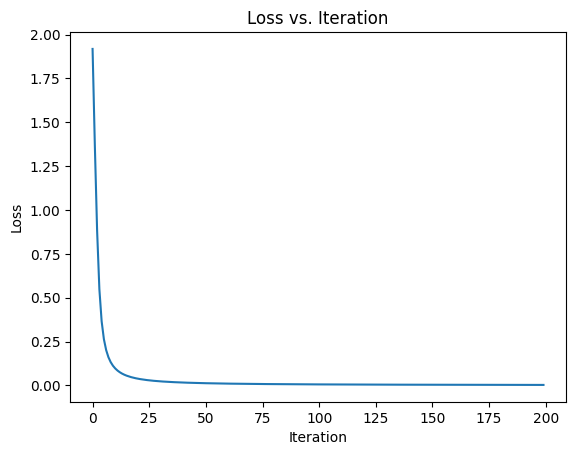

In [175]:
plot_losses(losses)

In [176]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [value.data for value in ypred]

print(f'\n- Results at end of iteration -')
print(f'ypred_data: {ypred_data}')
print(f'loss: {loss.data}')  


- Results at end of iteration -
ypred_data: [0.9589205712046247, -0.9705845876477089]
loss: 0.002552785954009626


In [177]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.17245051  0.38900459]
 [ 0.7242305  -0.66367658]
 [ 0.10965046 -0.96152738]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[ 1.5119148   0.12834693]
 [-0.54256874  2.83636809]
 [-2.66528123  1.29047875]]

bias (3, 1):
[[-0.44693868]
 [-0.78858122]
 [ 0.39480862]]

weights_x_inputs_+_bias (3, 2):
[[ 1.06497612 -0.31859175]
 [-1.33114995  2.04778687]
 [-2.27047262  1.68528737]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.78756095 -0.30823302]
 [-0.86953011  0.96725273]
 [-0.97889837  0.93354432]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[ 0.34572113 -0.20810172 -0.96683627]
 [-0.0880444  -0.66266925 -0.56569031]
 [ 0.1713961   0.53972697 -1.08198743]]

input (3, 2):
[[ 0.78756095 -0.30823302]
 [-0.86953011  0.96725273]
 [-0.97889837  0.93354432]]

weights_x_inputs (3, 2):
[[ 1.39966162 -1.21043413

### Build same model with pyTorch 

In [178]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 0.6168966293334961
Epoch 10 loss: 0.03802110627293587
Epoch 20 loss: 0.001195356948301196
Epoch 30 loss: 3.157670653308742e-05

Prediction:
tensor([[ 0.9988],
        [-0.9995]])
Loss: 1.1699459037117776e-06


In [179]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.196320652961731
Epoch 10 loss: 0.5280604958534241
Epoch 20 loss: 0.03164616972208023
Epoch 30 loss: 0.0004391155962366611

Prediction:
tensor([[ 0.9969],
        [-0.9989]])
Loss: 8.267299563158303e-06


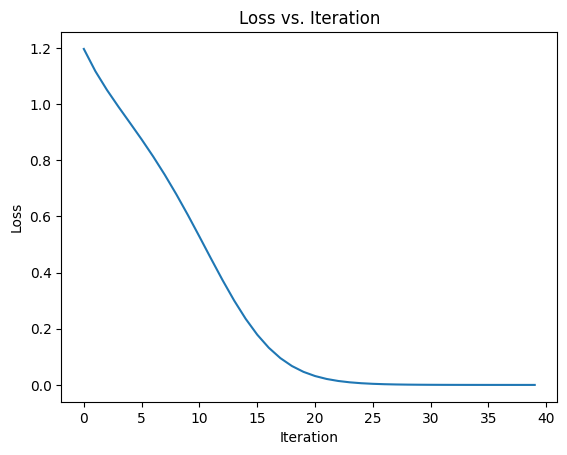

In [180]:
plot_losses(losses)

In [181]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[ 0.0424, -0.4262,  0.4276],
        [-0.0522, -0.4877,  0.1308],
        [ 0.0868,  0.4881,  0.4419],
        [-0.3580, -0.0309, -0.0769]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-1.6215,  0.7671],
        [-1.6983,  0.3965],
        [ 1.1960, -0.0067],
        [-0.7317, -1.0815]])

bT,  torch.Size([4, 1]):
tensor([[0.0527],
        [0.5007],
        [0.1102],
        [0.3897]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-1.5688,  0.8198],
        [-1.1976,  0.8972],
        [ 1.3063,  0.1036],
        [-0.3420, -0.6917]])

output,  torch.Size([4, 2]):
tensor([[-0.9168,  0.6749],
        [-0.8329,  0.7149],
        [ 0.8633,  0.1032],
        [-0.3293, -0.5991]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.4616, -0.2258,  

In [182]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [183]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9969, -0.9989]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(5.3264e-06)

In [184]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9969, -0.9989]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0031,  0.0011]])
squared_difference: tensor([[9.3890e-06, 1.2637e-06]])


tensor(5.3264e-06)

In [185]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.9969358444213867, -0.9988758563995361]

In [186]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

5.3263741222053795e-06


In [187]:
len(squared_difference)


1

In [188]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(5.3264e-06)

In [189]:
torch.sum((output - torch.tensor(ys))**2)


tensor(1.0653e-05)

##### Check Output and Gradient Calculation with PyTorch

In [190]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [191]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [192]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,  -0.1281754915
i:  1,   0.6671491703
i:  2,  -0.5124164265
i:  3,  -0.7039222188
i:  4,   0.2992982102
---
i: 36,  -0.0656490689
i: 37,   0.3360010803
i: 38,   0.4356097974
i: 39,   0.6610155946
i: 40,   0.5072641855


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [193]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [194]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0: -0.1281755,   w0.grad:  0.0000000
w1:  0.6671492,   w1.grad:  0.0000000
w2: -0.5124164,   w2.grad:  0.0000000
b:  -0.7039222

layer: 0, neuron 1
w0:  0.2992982,   w0.grad:  0.0000000
w1:  0.4842245,   w1.grad:  0.0000000
w2: -0.8111033,   w2.grad:  0.0000000
b:   0.3960032

layer: 0, neuron 2
w0:  0.9520509,   w0.grad:  0.0000000
w1: -0.6221582,   w1.grad:  0.0000000
w2: -0.4738425,   w2.grad:  0.0000000
b:  -0.9232978

layer: 0, neuron 3
w0: -0.4516930,   w0.grad:  0.0000000
w1:  0.0017586,   w1.grad:  0.0000000
w2:  0.2016866,   w2.grad:  0.0000000
b:  -0.9550977

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0: -0.6859043,   w0.grad:  0.0000000
w1: -0.8740098,   w1.grad:  0.0000000
w2: -0.9020706,   w2.grad:  0.0000000
w3:  0.9804493,   w3.grad:  0.0000000
b:  -0.9426405

layer: 1, neuron 1
w0: -0.0249025,   w0.grad:  0.0000000
w1:  0.6937777,   w1.grad:  0.0000000
w2:  0.6640865,   w2.grad:  0.0000000
w3: -

##### Print Neural Network's Weights and Biases Matrices

In [195]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[-0.12817549  0.66714917 -0.51241643]
 [ 0.29929821  0.48422452 -0.81110326]
 [ 0.95205094 -0.62215817 -0.47384253]
 [-0.45169296  0.00175857  0.20168658]]
b_mat(1, 4):
[[-0.70392222  0.39600319 -0.92329782 -0.95509769]]

i: 1
w_mat(4, 4):
[[-0.68590427 -0.87400983 -0.90207061  0.98044931]
 [-0.02490251  0.69377773  0.66408651 -0.08592319]
 [ 0.22110706  0.1838988  -0.02747578  0.58563712]
 [ 0.04353149  0.43643585 -0.54346388  0.52168908]]
b_mat(1, 4):
[[-0.94264046 -0.74276295 -0.47394185  0.32459546]]

i: 2
w_mat(1, 4):
[[-0.06564907  0.33600108  0.4356098   0.66101559]]
b_mat(1, 1):
[[0.50726419]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [196]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[-0.12817549  0.66714917 -0.51241643]
 [ 0.29929821  0.48422452 -0.81110326]
 [ 0.95205094 -0.62215817 -0.47384253]
 [-0.45169296  0.00175857  0.20168658]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[ 2.25751295 -1.30788386]
 [ 2.86237325  0.00811848]
 [ 0.5114699   3.24138971]
 [-1.09979681 -1.25599416]]

bias (4, 1):
[[-0.70392222]
 [ 0.39600319]
 [-0.92329782]
 [-0.95509769]]

weights_x_inputs_plus_bias (4, 2):
[[ 1.55359074 -2.01180608]
 [ 3.25837645  0.40412167]
 [-0.41182792  2.31809188]
 [-2.0548945  -2.21109185]]

output (4, 2):
[[ 0.91437601 -0.96485226]
 [ 0.99704744  0.38347009]
 [-0.39002364  0.98079692]
 [-0.96770749 -0.976269  ]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[-0.68590427 -0.87400983 -0.90207061  0.98044931]
 [-0.02490251  0.69377773  0.66408651 -0.08592319]
 [ 0.22110706  0.1838988  -0.02747578  0.58563712]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [197]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.5019909241212005, -0.05208824277320446]
ys:                 [1.0, -1.0]
loss_data:          1.1465497391464472


#### Micrograd backward pass and update parameters

In [198]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0     -0.1281754915    -0.0028290402           0.05000        -0.1280340395
  1      0.6671491703    -0.0350086550           0.05000         0.6688996030
  2     -0.5124164265     0.0126018273           0.05000        -0.5130465179
  3     -0.7039222188    -0.0042113469           0.05000        -0.7037116514
  4      0.2992982102     2.1624483374           0.05000         0.1911757933
  5      0.4842245232    -0.7288608957           0.05000         0.5206675680
  6     -0.8111032605     0.3633334320           0.05000        -0.8292699321
  7      0.3960031948     0.7200847685           0.05000         0.3599989564
  8      0.9520509350     0.0877454907           0.05000         0.9476636605
  9     -0.6221581667     0.1527132964           0.05000        -0.6297938316
 10     -0.4738425329    -0.0515436764           0.05000        -0.4712653491
 11     -0.9232978203     0.0457904781

### Improve Prediction with Parameter Iteration 

In [199]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.4472124617226206), Value(data = -0.48177785542035195)]
step: 0, loss: 0.5741282536074949
-------
ypred: [Value(data = 0.5412689601789028), Value(data = -0.5717731451547924)]
step: 1, loss: 0.3938124061059636
-------
ypred: [Value(data = 0.6057925350114782), Value(data = -0.6281763332630568)]
step: 2, loss: 0.29365236459838207
-------
ypred: [Value(data = 0.6515815141208714), Value(data = -0.6677902671288679)]
step: 3, loss: 0.2317587479166135
-------
ypred: [Value(data = 0.6858800327137266), Value(data = -0.6976162307446732)]
step: 4, loss: 0.19010729775698826
-------
ypred: [Value(data = 0.712700206143804), Value(data = -0.721143657740203)]
step: 5, loss: 0.16030203116832578
-------
ypred: [Value(data = 0.7343682105332687), Value(data = -0.7403224417086768)]
step: 6, loss: 0.13799268185544142
-------
ypred: [Value(data = 0.7523185602560675), Value(data = -0.7563419592618432)]
step: 7, loss: 0.12071533640998455
-------
ypred: [Value(data = 0.7674856425194572), Va

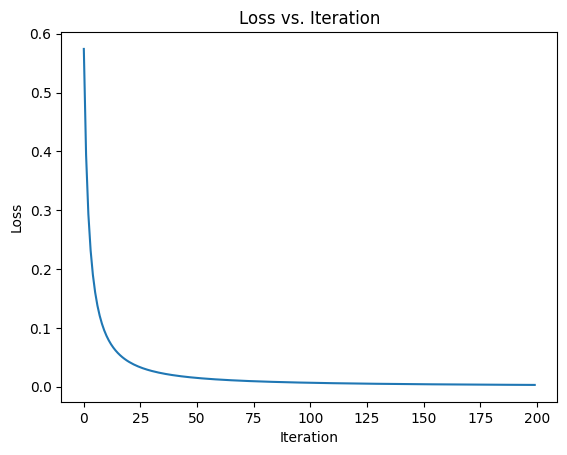

In [200]:
plot_losses(losses)

### Build same model with pyTorch 

In [201]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.8646681308746338
Epoch 10 loss: 0.29356902837753296
Epoch 20 loss: 0.015166179277002811
Epoch 30 loss: 0.00046875770203769207

Prediction:
tensor([[ 0.9970],
        [-0.9958]])
Loss: 1.897605943668168e-05


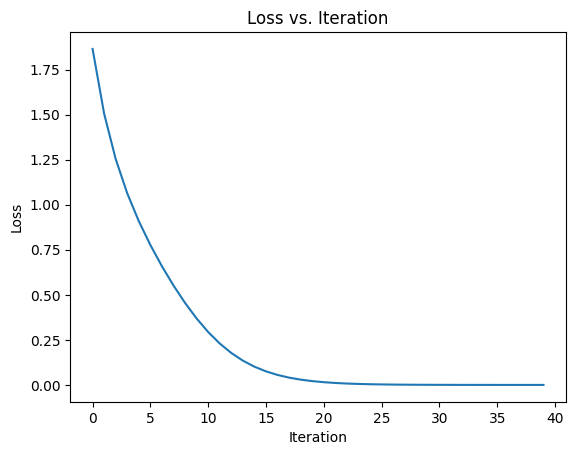

In [202]:
plot_losses(losses)

In [203]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[ 0.1491, -0.4186,  0.0323],
        [ 0.2461, -0.3349,  0.4225],
        [ 0.4285,  0.2990,  0.1289],
        [ 0.2831, -0.2436,  0.6166]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-0.9899,  0.8821],
        [-0.9351,  1.2845],
        [ 1.6251,  1.0510],
        [-0.7813,  1.4012]])

bT,  torch.Size([4, 1]):
tensor([[-0.2925],
        [-0.0664],
        [ 0.3077],
        [-0.2795]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-1.2824,  0.5896],
        [-1.0015,  1.2181],
        [ 1.9327,  1.3587],
        [-1.0608,  1.1217]])

output,  torch.Size([4, 2]):
tensor([[-0.8571,  0.5296],
        [-0.7622,  0.8391],
        [ 0.9590,  0.8761],
        [-0.7860,  0.8082]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[ 0.2667,  0.244

In [204]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [205]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9970, -0.9958]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(2.6553e-05)

In [206]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9970, -0.9958]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0030,  0.0042]])
squared_difference: tensor([[8.7177e-06, 1.7836e-05]])


tensor(1.3277e-05)

In [207]:
difference
len(squared_difference)

1

In [208]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(1.3277e-05)

In [209]:
torch.sum((output - torch.tensor(ys))**2)

tensor(2.6553e-05)